# TP1 - Redes Neuronales II (parte 3 de 3)
## Francisco Mendizabal
## Legajo 61454

## Consignas:

### 5- Construir la matriz término-término utilizando una ventana de contexto. Para construir esta matriz serán útiles las funcionalidades de Keras make_sampling_table, skipgrams y el tokenizador de Keras. Explorar resultados de similaridad de términos con diferentes tamaños de contexto.

### 6- Con la matriz término-término construir la matriz de PPMI y factorizarla aplicando truncated SVD. Explorar resultados de similaridad término a término.

## Setup

In [332]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import make_sampling_table, skipgrams
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix
import umap.umap_ as umap
import numpy as np

In [333]:
TNG_train = fetch_20newsgroups(subset="train", remove=('headers', 'footers', 'quotes'))

In [334]:
cv1 = CountVectorizer(ngram_range=(1,2), max_df=0.8, min_df=1e-3, max_features=None, stop_words="english")
cv2 = TfidfVectorizer(ngram_range=(1,1), max_df=0.8, min_df=1e-3, max_features=None, stop_words="english")

In [335]:
# Configuro si quiero CountVectorizer o TFIDF
cv = cv2

In [336]:
TNG_cv = cv.fit_transform(TNG_train.data)
print(TNG_cv.shape)

(11314, 9052)


In [337]:
#Tamaño del vocabulario
print(f'El tamaño del vocabulario es: {len(cv.get_feature_names_out())}')

El tamaño del vocabulario es: 9052


## Matriz Termino-Termino

In [338]:
# Tamaño de contexto
W = 10000
V = W + 1

# Configuro si quiero PPMI o no
PPMI = False
PMI = 0

In [339]:
tokenizer = Tokenizer(num_words=W)
tokenizer.fit_on_texts(TNG_train.data)

In [340]:
seqs=tokenizer.texts_to_sequences(TNG_train.data)
print(seqs[0][0:10])

[7, 26, 1383, 24, 160, 64, 43, 105, 61, 15]


In [341]:
counts_matrix = lil_matrix((W, W))

In [342]:
seqs=np.hstack(seqs)
print(seqs.shape)

(2153559,)


In [343]:
seqs = seqs.astype(int)
pairs, labels = skipgrams(sequence=list(seqs), vocabulary_size=V, window_size=5, negative_samples=0, 
                          sampling_table=make_sampling_table(V, sampling_factor=1), shuffle=False)

In [344]:
pairs_u, counts = np.unique(pairs, return_counts=True, axis=0)
len(pairs_u)

4127751

In [345]:
for num, (pair, count) in enumerate(zip(pairs_u, counts)):
    if num % 1000 == 0:
        print(f'\r{num}', end="")
    counts_matrix[pair[0], pair[1]] += count

4127000

In [346]:
counts_matrix.shape

(10000, 10000)

In [347]:
if PPMI:
    PMI = counts_matrix[1:,1:].sum(axis=1)/counts_matrix[1:,1:].sum()
    print(PMI.shape)

In [348]:
if PPMI:
    probs = counts_matrix[1:,1:]/counts_matrix[1:,1:].sum()
    PMI = probs/np.dot(PMI, PMI.T)
    PMI = np.array(PMI)
    print(PMI)

In [349]:
if PPMI:
    PMI = PMI*(PMI>1)+1e-8
    PMI = np.log(PMI)
    PMI = PMI*(PMI>0)+1e-8
    print(PMI)

In [350]:
red = TruncatedSVD(n_components=300)
TNG_cv_red = 0

if PPMI:
    TNG_cv_red = red.fit_transform(PMI)
else:
    TNG_cv_red = red.fit_transform(counts_matrix)

print(TNG_cv_red.shape)

(10000, 300)


In [351]:
neigh = NearestNeighbors(n_neighbors=20, metric="cosine")

In [352]:
neigh.fit(TNG_cv_red)

NearestNeighbors(metric='cosine', n_neighbors=20)

In [353]:
# Palabra a partir de la cual se buscarán los vecinos (key)
key = cv.get_feature_names_out()[7272]
print(key)

scrutiny


In [354]:
idx_1 = tokenizer.word_index[key]
_, neig = neigh.kneighbors(TNG_cv_red[idx_1:idx_1+1])
print(idx_1)

8896


In [355]:
# Se obtienen las palabras vecinas a la key
for n in neig[0]:
    print(tokenizer.index_word[n])

scrutiny
encryption
artificial
private
thus
policy
its
safety
activity
security
property
economic
punishment
equipment
purpose
truth
privacy
natural
justice
death


In [356]:
X_embedded_tsne = umap.UMAP(n_components=2, metric="cosine").fit_transform(TNG_cv_red)
print(X_embedded_tsne.shape)

(10000, 2)


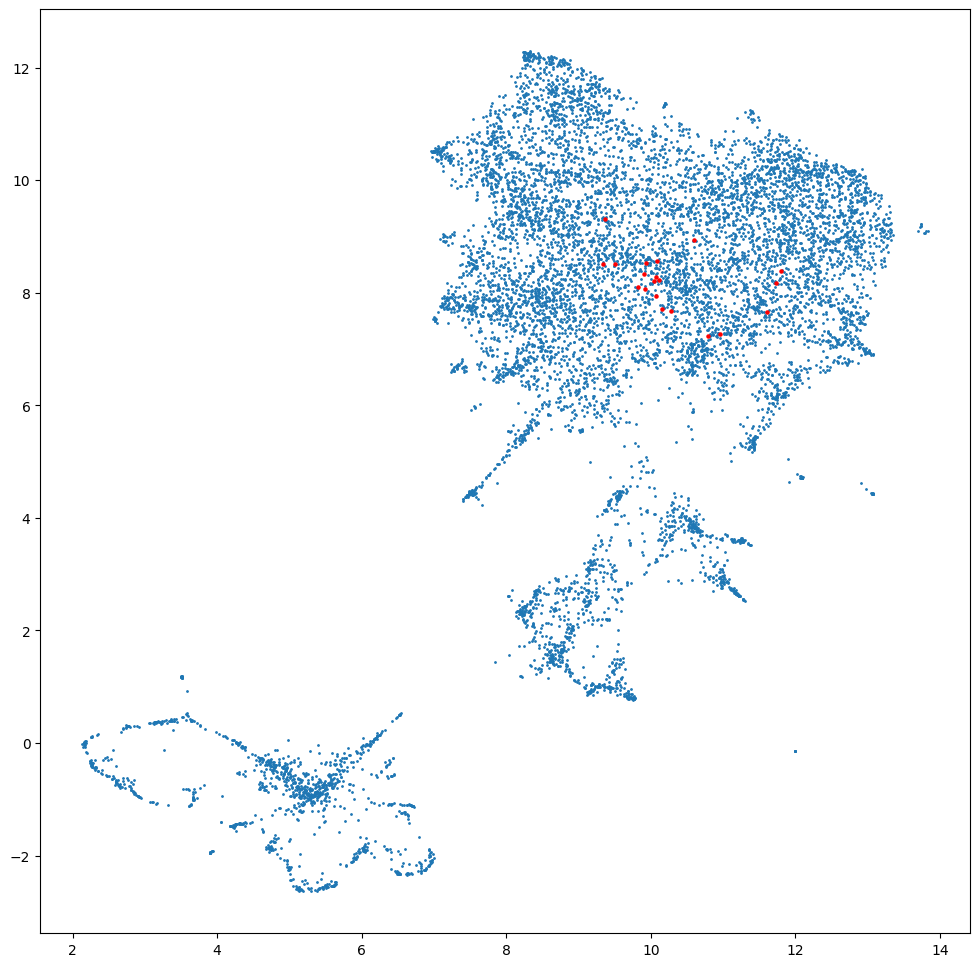

In [357]:
plt.figure(figsize=[12, 12])
plt.scatter(X_embedded_tsne[:,0], X_embedded_tsne[:,1], s=1)
words=[cv.get_feature_names_out()[i] for i in neig[0]]
for word in words:
    idx = cv.vocabulary_[word]
    plt.scatter(X_embedded_tsne[idx, 0], X_embedded_tsne[idx, 1], s=5, color='red')

![PPMIn't 6k.png](<attachment:PPMIn't 6k.png>) 
Sin PPMI, con 6000 palabras en el vocabulario.
![PPMIn't 11k.png](<attachment:PPMIn't 11k.png>) 
Sin PPMI, con 11000 palabras en el vocabulario.
![PPMI 6k.png](<attachment:PPMI 6k.png>) 
Con PPMI, con 6000 palabras en el vocabulario.
![PPMI 11k.png](<attachment:PPMI 11k.png>)
Con PPMI, con 11000 palabras en el vocabulario.
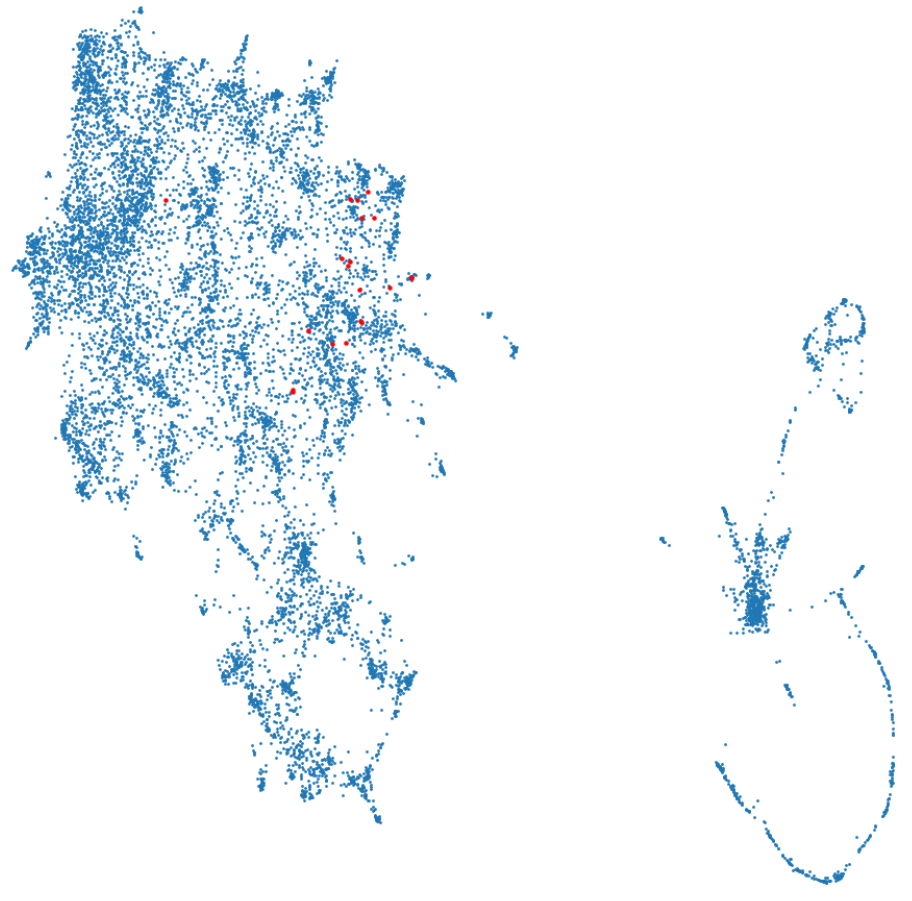
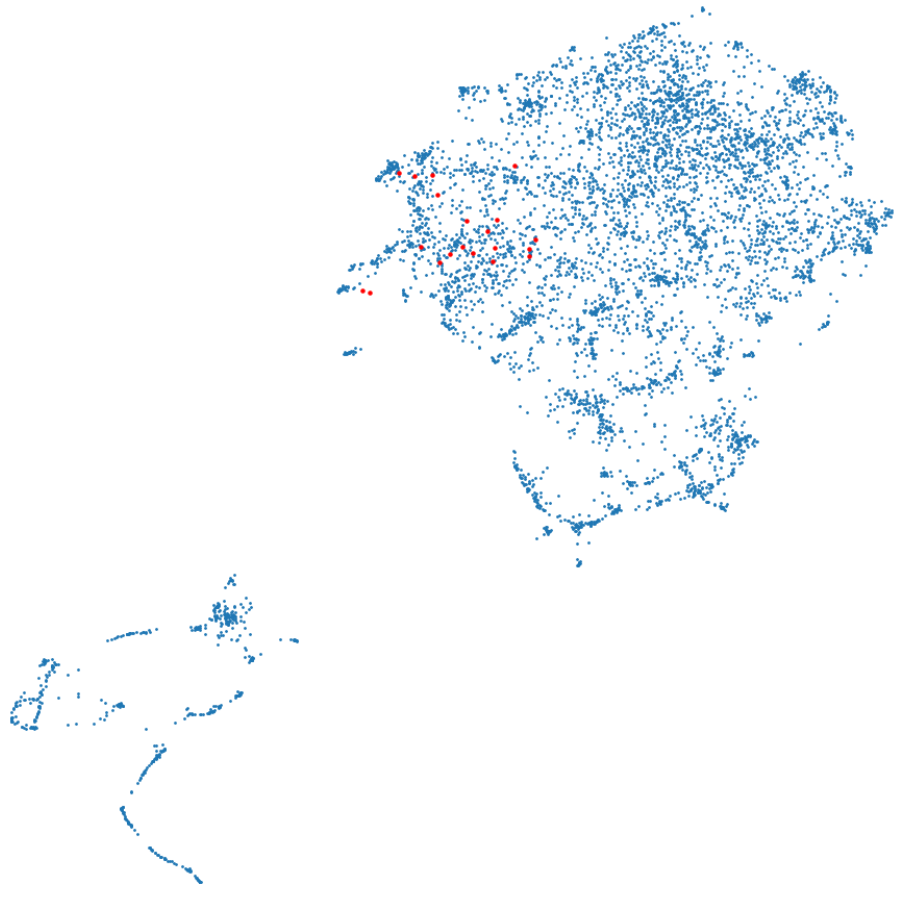
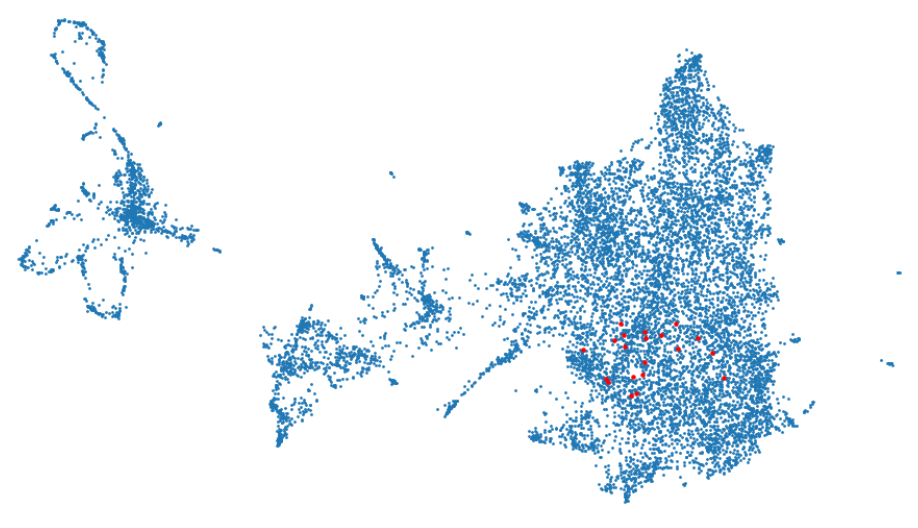
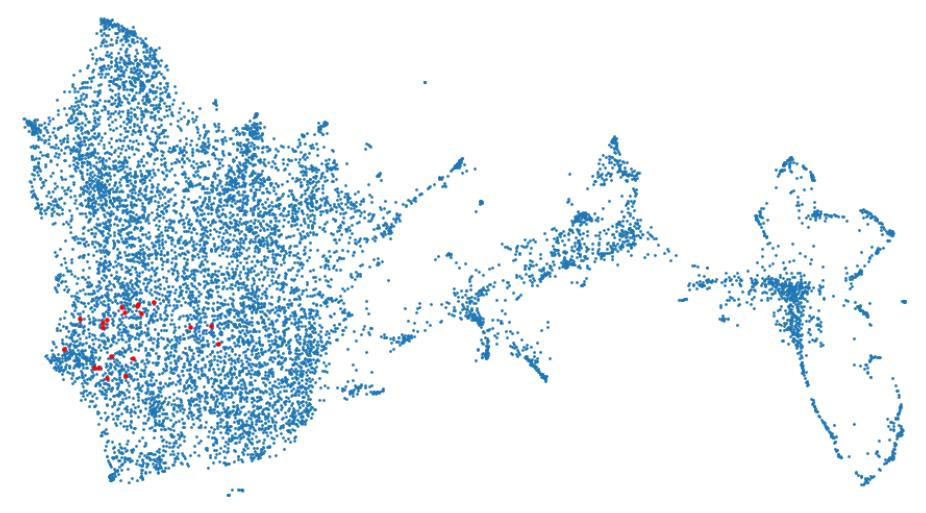

### En todos los gráficos se observa una gran dispersión en las palabras vecinas obtenidas, así como también grupos de palabras completamente disjuntos, lo cual no parecen buenos indicios. Desconozco a qué se deben estos resultados.

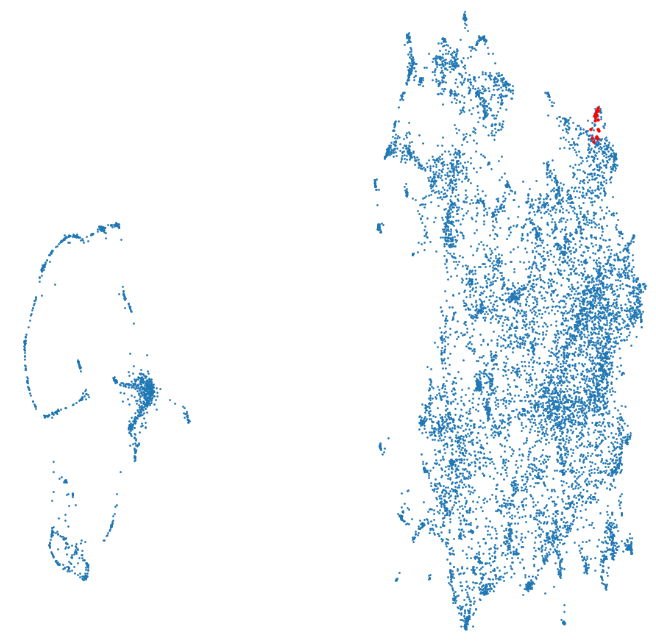

Con PPMI, con 10000 palabras en el vocabulario (usando TFIDF).

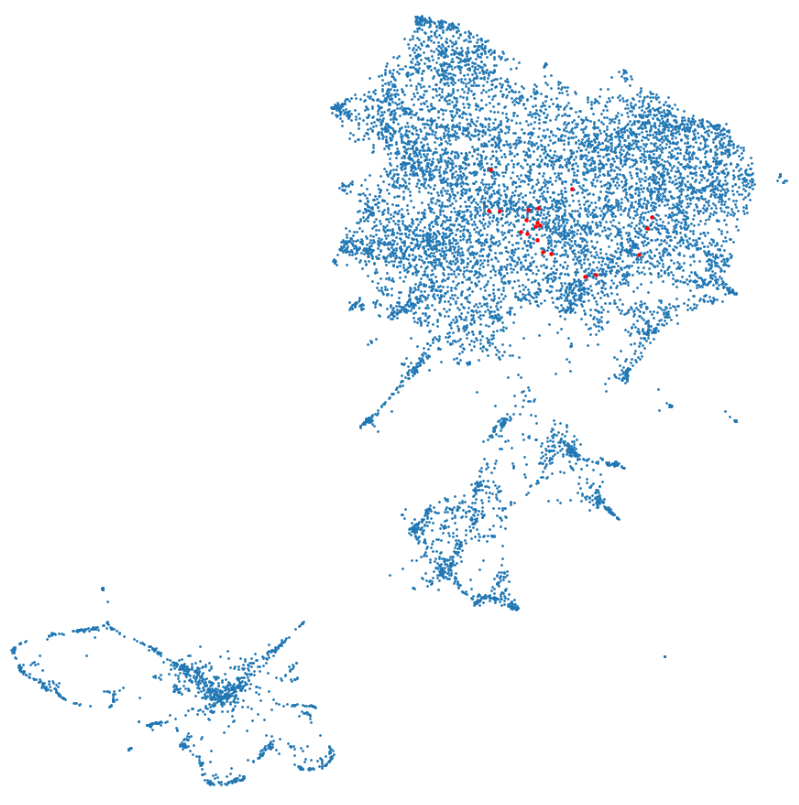

Sin PPMI, con 10000 palabras en el vocabulario (usando TFIDF).

### Al reemplazar CV por TFIDF, cuando se combina con PPMI, las palabras vecinas vuelven a acercarse en el gráfico. Sin embargo, los grupos disjuntos persisten.